# How can we infer the cell connection expansion directions ? 

#### In this notebook we want to reproduce the figure 6.A (but with violin plot rather than bar plot) and 6.C of the article “Why plants make puzzle cells, and how their shape emerges", A. Sapala et al with our cleaned database.


#### First, we make 1 csv for each image composed of a dataframe with :

#### - area of each cell 
#### - cell identification
#### - area of each cell
#### - perimeter of each cell
#### - perimeter of the convex hull of each cell


In [113]:
# We import some existent libraries 

from tifffile import imread
import napari
from skimage import restoration
import skimage.filters as filters
from skimage.morphology import disk
from skimage import morphology
from skimage.feature import peak_local_max
from skimage.morphology import convex_hull_image
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import numpy as np
import pandas as pd
from skimage import measure
import matplotlib.pyplot as plot
import tifffile
from scipy import ndimage as ndi
import skimage
from skimage.color import rgb2gray
from typing import List
from magicgui import magicgui
from napari.types import ImageData, LabelsData, LayerDataTuple
import numpy as np
import glob
from skimage import feature
from skimage.measure import regionprops_table
from skimage.util import map_array


In [114]:
# We import the useful functions from the script save in the src folder
from src.utils import * # import all functions

## All user choice 

In [115]:
data_folder_path = "./"

In [116]:
# We import our csv containing the cell database cleaned ()

database_path = data_folder_path  + 'data/cleaned/global_database_cleaned.csv'                                                                                         
df = pd.read_csv(database_path)                                                                     
df    

,plant_name,cell_fname,leaf_id,leaf_orientation,group
0,Ceratostigma_minus,3-07-400x-1-01,3.70,abaxial,1
1,Ceratostigma_minus,3-07-400x-1-02,3.70,abaxial,1
2,Ceratostigma_minus,3-07-400x-1-03,3.70,abaxial,1
3,Ceratostigma_minus,3-07-400x-1-04,3.70,abaxial,1
4,Ceratostigma_minus,3-07-400x-2-01,3.70,adaxial,1
...,...,...,...,...,...
84,Hemerocallis_fulva,7-24-400x-1-05,7.24,abaxial,5
85,Jasminum fruticans,8-06-700x-2-01,8.60,NaN,3
86,Jasminum fruticans,8-06-700x-2-02,8.60,NaN,3
87,Jasminum fruticans,8-06-700x-2-03,8.60,NaN,3


In [117]:
# path of the masks and lobeyness

mask_paths = "results/cell_mask/"
result_path = data_folder_path + "results/lobeyness/" 

mask_paths = glob.glob(mask_paths + "*.tif") # glob recherche tous les chemins des tiff files

mask_path = mask_paths[0] # for each image
mask_path

'results/cell_mask/5-22-400x-1-02.tif'

In [118]:
# on ouvre les masques

mask = tifffile.imread(mask_path)

# open napari viewer

viewer = napari.Viewer()
viewer.add_labels(mask)

<Labels layer 'mask' at 0x1a3fd3160>

In [119]:
# compute features of the area, perimeter and perimeter of the convex hull of each cell

table = regionprops_table(
        mask,
        properties=['label', 'perimeter', 'area'],
        extra_properties=(convex_hull,)) # just give the created convex_hull function in a tuple

table = pd.DataFrame(table) # create a dataframe
table

,label,perimeter,area,convex_hull
0,1,171.675144,1909,171.053824
1,2,239.965512,2480,226.409163
2,3,267.764502,2281,246.492424
3,4,227.965512,2936,226.793939
4,5,168.568542,1794,168.568542
...,...,...,...,...
280,281,192.107648,1436,171.438600
281,282,215.195959,2333,211.053824
282,283,211.338095,2005,205.195959
283,284,197.396970,2139,197.396970


### Secondly, we make 1 general csv composed of a dataframe with :
#### - the name of the image 
#### - cell-identification 
#### - area of the cells of the image 
#### - species
#### - lobeyness 



In [120]:
# we create empty lists for the area, lobeyness and image identification now

area = []
lobeyness = []
image_id = []

In [121]:
#open napari viewer

viewer = napari.Viewer()
viewer.add_labels(mask)

# to get the path of the masks

mask_paths = glob.glob("results/cell_mask/*.tif")

# boucle pour avoir toutes les images

for mask_path in mask_paths: # pour chaque image dans toutes les images
    
    print(mask_path)
    mask = tifffile.imread(mask_path) # ouvrir le path du mask
# compute features of the area, perimeter and perimeter of the convex hull of each cell
    table = regionprops_table(
           mask,
           properties=('label', 'perimeter', 'area'),
           extra_properties=(convex_hull,)) # just give the convex_hull function in a tuple

    table = pd.DataFrame(table) # create a dataframe
    table = table.assign(lobeyness = table["perimeter"]/table["convex_hull"]) # get lobeyness : the perimeter of the cell divided by the perimeter of its convex hull, we add it to the dataframe

# image identification
    file_path = mask_path.split("/")[-1]
    table["image_id"] = mask_path.split("/")[-1] # get all the images in table
    
    # add to our lists
    area = area + list(table["area"])
    lobeyness = lobeyness + list(table["lobeyness"])
    image_id = image_id + list(table["image_id"])

# save to csv :
    table.to_csv(result_path + file_path.replace(".tif", ".csv"))

    print(table.head(18))



results/cell_mask/5-22-400x-1-02.tif
    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   171.675144   1909   171.053824   1.003632  5-22-400x-1-02.tif
1       2   239.965512   2480   226.409163   1.059875  5-22-400x-1-02.tif
2       3   267.764502   2281   246.492424   1.086299  5-22-400x-1-02.tif
3       4   227.965512   2936   226.793939   1.005166  5-22-400x-1-02.tif
4       5   168.568542   1794   168.568542   1.000000  5-22-400x-1-02.tif
5       6   900.222438  13307   578.835570   1.555230  5-22-400x-1-02.tif
6       7   428.753355   4137   349.906638   1.225336  5-22-400x-1-02.tif
7       8   892.045815  12473   616.842712   1.446148  5-22-400x-1-02.tif
8       9  1066.714862  14390   569.587878   1.872784  5-22-400x-1-02.tif
9      10   324.042677   5223   315.078210   1.028452  5-22-400x-1-02.tif
10     11   291.622366   3228   276.107648   1.056191  5-22-400x-1-02.tif
11     12   196.551299   2391   195.137085   1.007247  5-22-400x-1-02.tif
1

    label   perimeter  area  convex_hull  lobeyness            image_id
0       1  213.338095  2058   208.852814   1.021476  5-22-400x-1-03.tif
1       2  247.580736  3173   242.024387   1.022958  5-22-400x-1-03.tif
2       3  219.574639  2406   215.882251   1.017104  5-22-400x-1-03.tif
3       4  251.764502  3117   237.379726   1.060598  5-22-400x-1-03.tif
4       5  266.024387  3668   261.296465   1.018094  5-22-400x-1-03.tif
5       6  239.539105  2842   229.597980   1.043298  5-22-400x-1-03.tif
6       7  211.237590  2341   203.681241   1.037099  5-22-400x-1-03.tif
7       8  820.613311  9542   482.617316   1.700340  5-22-400x-1-03.tif
8       9  309.119841  3170   302.676190   1.021289  5-22-400x-1-03.tif
9      10  403.812229  6196   354.048773   1.140555  5-22-400x-1-03.tif
10     11   24.899495    42    27.313708   0.911612  5-22-400x-1-03.tif
11     12  187.095454  1705   171.195959   1.092873  5-22-400x-1-03.tif
12     13  172.325902  1709   171.497475   1.004831  5-22-400x-1

    label    perimeter    area  convex_hull  lobeyness            image_id
0       1  1201.472222   28763   874.031529   1.374633  7-01-700x-t-02.tif
1       2  4930.108186  106906  2958.097546   1.666648  7-01-700x-t-02.tif
2       3   660.530050    8831   536.551299   1.231066  7-01-700x-t-02.tif
3       4  1576.541377   39524  1030.773737   1.529474  7-01-700x-t-02.tif
4       5  1005.478318   13362   819.663997   1.226696  7-01-700x-t-02.tif
5       6   893.685425   11550   564.080303   1.584323  7-01-700x-t-02.tif
6       7   611.097546    8550   528.994949   1.155205  7-01-700x-t-02.tif
7       8   434.286363    4729   311.178716   1.395617  7-01-700x-t-02.tif
8       9  1154.793073   18458   941.362482   1.226725  7-01-700x-t-02.tif
9      10   238.474134    2667   234.953319   1.014985  7-01-700x-t-02.tif
10     11   961.620454   14715   775.411255   1.240143  7-01-700x-t-02.tif
11     12   495.457936    9959   450.492424   1.099814  7-01-700x-t-02.tif
12     13   371.333044   

    label    perimeter   area  convex_hull  lobeyness             image_id
0       1   335.480231   2801   316.568542   1.059740  7-01-700x-t2-01.tif
1       2   365.030483   2188   350.811183   1.040533  7-01-700x-t2-01.tif
2       3   406.125938   4699   316.994949   1.281175  7-01-700x-t2-01.tif
3       4   330.865007   5442   310.509668   1.065555  7-01-700x-t2-01.tif
4       5   374.368578   6166   347.563492   1.077123  7-01-700x-t2-01.tif
5       6   381.487373   3851   319.806133   1.192871  7-01-700x-t2-01.tif
6       7   326.214249   4853   294.811183   1.106519  7-01-700x-t2-01.tif
7       8   858.731060   9998   658.894444   1.303291  7-01-700x-t2-01.tif
8       9   537.718867   5619   395.688384   1.358945  7-01-700x-t2-01.tif
9      10  1082.987986  12810   624.114790   1.735238  7-01-700x-t2-01.tif
10     11   448.416306   3652   414.350288   1.082216  7-01-700x-t2-01.tif
11     12   256.078210   2541   226.509668   1.130540  7-01-700x-t2-01.tif
12     13   375.008189   

    label   perimeter  area  convex_hull  lobeyness            image_id
0       1  227.787843  1306   220.994949   1.030738  3-07-400x-1-02.tif
1       2  170.846717  1353   165.840620   1.030186  3-07-400x-1-02.tif
2       3   60.834524   182    63.455844   0.958691  3-07-400x-1-02.tif
3       4  245.279221  2790   236.592929   1.036714  3-07-400x-1-02.tif
4       5  483.665043  5434   396.066017   1.221173  3-07-400x-1-02.tif
5       6  246.101551  1962   233.195959   1.055342  3-07-400x-1-02.tif
6       7   59.455844   208    55.313708   1.074884  3-07-400x-1-02.tif
7       8  394.634560  3547   274.468037   1.437816  3-07-400x-1-02.tif
8       9  259.823376  2157   238.124892   1.091122  3-07-400x-1-02.tif
9      10  236.551299  2249   220.852814   1.071081  3-07-400x-1-02.tif
10     11  267.592929  2226   249.338095   1.073213  3-07-400x-1-02.tif
11     12  473.203102  5668   322.308658   1.468168  3-07-400x-1-02.tif
12     13  192.059921  1772   183.154329   1.048623  3-07-400x-1

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1  1929.281492  32776   904.600072   2.132745  6-21-400x-2-03.tif
1       2    92.012193    376    87.355339   1.053309  6-21-400x-2-03.tif
2       3   390.190909   4713   344.894444   1.131334  6-21-400x-2-03.tif
3       4   706.476226  15576   598.634560   1.180146  6-21-400x-2-03.tif
4       5   828.607214  16515   636.249783   1.302330  6-21-400x-2-03.tif
5       6   608.298557  10785   502.132034   1.211431  6-21-400x-2-03.tif
6       7  1003.058008  20419   693.695526   1.445963  6-21-400x-2-03.tif
7       8   768.884343  12047   619.806133   1.240524  6-21-400x-2-03.tif
8       9   870.862048  17525   602.600072   1.445174  6-21-400x-2-03.tif
9      10   540.575685   7555   432.107648   1.251021  6-21-400x-2-03.tif
10     11   235.681241   2744   225.882251   1.043381  6-21-400x-2-03.tif
11     12  1032.040764  21101   718.523953   1.436335  6-21-400x-2-03.tif
12     13  1061.065151  20222   696.15

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   315.858910   3654   300.325902   1.051721  7-15-400x-2-03.tif
1       2   443.634560   6246   396.769553   1.118116  7-15-400x-2-03.tif
2       3   403.693434   5354   367.597980   1.098193  7-15-400x-2-03.tif
3       4  1125.637698  24661   772.783838   1.456601  7-15-400x-2-03.tif
4       5   422.184812   6907   389.154329   1.084878  7-15-400x-2-03.tif
5       6   458.563492   6559   437.095454   1.049115  7-15-400x-2-03.tif
6       7   336.373629   3464   310.627417   1.082885  7-15-400x-2-03.tif
7       8   679.068109  14110   616.048773   1.102296  7-15-400x-2-03.tif
8       9   258.580736   2614   242.024387   1.068408  7-15-400x-2-03.tif
9      10   504.002092  11533   477.989899   1.054420  7-15-400x-2-03.tif
10     11   592.570635  14606   543.119841   1.091050  7-15-400x-2-03.tif
11     12   395.279221   8213   365.195959   1.082376  7-15-400x-2-03.tif
12     13   488.031529  12200   445.92

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   313.480231   3749   283.923882   1.104100  4-17-400x-2-01.tif
1       2   846.217388  19888   657.605122   1.286817  4-17-400x-2-01.tif
2       3  1430.024566  39607   969.300649   1.475316  4-17-400x-2-01.tif
3       4    33.106602     51    35.899495   0.922202  4-17-400x-2-01.tif
4       5   251.237590   3041   245.095454   1.025060  4-17-400x-2-01.tif
5       6   495.345238  12587   474.859956   1.043140  4-17-400x-2-01.tif
6       7   235.053824   2303   225.941125   1.040332  4-17-400x-2-01.tif
7       8   591.872150  16069   543.747258   1.088506  4-17-400x-2-01.tif
8       9   516.646753  11653   469.137085   1.101270  4-17-400x-2-01.tif
9      10   817.381818  23388   659.085353   1.240176  4-17-400x-2-01.tif
10     11   339.036580   4534   311.338095   1.088966  4-17-400x-2-01.tif
11     12   957.353426  25600   806.641702   1.186838  4-17-400x-2-01.tif
12     13   303.030483   4775   290.81

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   342.267027   2591   332.325902   1.029914  4-02-700x-1-05.tif
1       2   398.391919   8580   379.036580   1.051065  4-02-700x-1-05.tif
2       3   586.321897   5001   398.409163   1.471658  4-02-700x-1-05.tif
3       4   572.031529  14305   537.646753   1.063954  4-02-700x-1-05.tif
4       5   304.208153   3838   297.480231   1.022616  4-02-700x-1-05.tif
5       6   466.014285  10584   442.031529   1.054256  4-02-700x-1-05.tif
6       7   241.338095   3261   233.539105   1.033395  4-02-700x-1-05.tif
7       8   598.842712   5897   436.433550   1.372128  4-02-700x-1-05.tif
8       9   174.195959   1202   156.911688   1.110153  4-02-700x-1-05.tif
9      10   553.646753   9019   527.948268   1.048676  4-02-700x-1-05.tif
10     11   928.500613  20118   622.232539   1.492208  4-02-700x-1-05.tif
11     12   201.597980   2437   199.941125   1.008287  4-02-700x-1-05.tif
12     13   995.087445   8774   508.19

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1  1039.886435  14665   599.369624   1.734967  4-15-400x-2-01.tif
1       2   321.220346   3393   275.078210   1.167742  4-15-400x-2-01.tif
2       3   281.202056   1556   264.669048   1.062467  4-15-400x-2-01.tif
3       4   586.440692   7692   448.149278   1.308583  4-15-400x-2-01.tif
4       5   577.126984   7714   462.735065   1.247208  4-15-400x-2-01.tif
5       6   802.737157  11542   596.818326   1.345028  4-15-400x-2-01.tif
6       7     0.000000      2     0.000000        NaN  4-15-400x-2-01.tif
7       8   434.048773   4750   379.557395   1.143566  4-15-400x-2-01.tif
8       9  2591.662264  48821  1129.511760   2.294498  4-15-400x-2-01.tif
9      10   340.871104   3830   308.024387   1.106637  4-15-400x-2-01.tif
10     11   836.506709  18683   624.215295   1.340093  4-15-400x-2-01.tif
11     12    59.727922    223    58.485281   1.021247  4-15-400x-2-01.tif
12     13   467.671140   6781   413.80

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1  3490.123338  52047  1328.045815   2.628014  4-15-400x-2-03.tif
1       2   436.285317   3216   360.450793   1.210388  4-15-400x-2-03.tif
2       3    49.935029     91    50.485281   0.989101  4-15-400x-2-03.tif
3       4   392.333044   5848   340.066017   1.153697  4-15-400x-2-03.tif
4       5  1069.495562  19850   803.796031   1.330556  4-15-400x-2-03.tif
5       6   581.162518   8984   438.977705   1.323900  4-15-400x-2-03.tif
6       7  4083.912227  72853  1562.642748   2.613465  4-15-400x-2-03.tif
7       8   457.185858   6402   380.960461   1.200087  4-15-400x-2-03.tif
8       9   800.063059  12560   592.156421   1.351101  4-15-400x-2-03.tif
9      10   682.678282  11957   527.671140   1.293757  4-15-400x-2-03.tif
10     11  1292.266161  27572   806.482323   1.602349  4-15-400x-2-03.tif
11     12  3768.002630  57710  1565.224530   2.407324  4-15-400x-2-03.tif
12     13   508.097546   8605   422.37

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   237.296465   3138   234.225397   1.013112  5-22-400x-2-01.tif
1       2  1036.187950  16373   586.960461   1.765345  5-22-400x-2-01.tif
2       3   219.438600   2408   216.953319   1.011455  5-22-400x-2-01.tif
3       4   187.539105   1885   185.882251   1.008913  5-22-400x-2-01.tif
4       5   143.497475    739   141.254834   1.015877  5-22-400x-2-01.tif
5       6   183.095454   1630   178.994949   1.022908  5-22-400x-2-01.tif
6       7   213.681241   1708   203.438600   1.050348  5-22-400x-2-01.tif
7       8   238.894444   2724   226.208153   1.056082  5-22-400x-2-01.tif
8       9   352.918831   3844   309.948268   1.138638  5-22-400x-2-01.tif
9      10   391.954365   4610   316.835570   1.237091  5-22-400x-2-01.tif
10     11   368.374675   3964   313.563492   1.174801  5-22-400x-2-01.tif
11     12     0.000000      2     0.000000        NaN  5-22-400x-2-01.tif
12     13     1.000000      3     1.00

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   931.342279  13074   562.357431   1.656139  4-01-700x-2-01.tif
1       2   315.036580   4320   313.622366   1.004509  4-01-700x-2-01.tif
2       3   276.338095   1843   280.953319   0.983573  4-01-700x-2-01.tif
3       4  1084.952452   8284   525.931024   2.062918  4-01-700x-2-01.tif
4       5   514.782792   7406   485.504617   1.060305  4-01-700x-2-01.tif
5       6   443.546248  10240   427.847763   1.036692  4-01-700x-2-01.tif
6       7   256.894444   3637   250.166522   1.026894  4-01-700x-2-01.tif
7       8   659.352380  14570   579.428499   1.137936  4-01-700x-2-01.tif
8       9   421.019336   9212   397.865007   1.058196  4-01-700x-2-01.tif
9      10   267.379726   3975   259.338095   1.031008  4-01-700x-2-01.tif
10     11   371.622366   5044   348.225397   1.067189  4-01-700x-2-01.tif
11     12   803.548340   5138   469.705627   1.710749  4-01-700x-2-01.tif
12     13     6.621320      7     8.24

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   400.936075   3946   367.982756   1.089551  4-01-700x-2-06.tif
1       2   266.391919   4376   258.977705   1.028629  4-01-700x-2-06.tif
2       3   217.503571   1713   220.710678   0.985469  4-01-700x-2-06.tif
3       4   497.404112   6825   450.651804   1.103744  4-01-700x-2-06.tif
4       5   289.231493   4328   288.610173   1.002153  4-01-700x-2-06.tif
5       6   183.474134   2027   183.681241   0.998872  4-01-700x-2-06.tif
6       7   500.031529   9621   476.215295   1.050011  4-01-700x-2-06.tif
7       8   395.806133   8624   386.936075   1.022924  4-01-700x-2-06.tif
8       9   457.906638  10337   448.793939   1.020305  4-01-700x-2-06.tif
9      10   279.882251   4942   278.468037   1.005079  4-01-700x-2-06.tif
10     11   371.119841   7618   366.977705   1.011287  4-01-700x-2-06.tif
11     12   320.787843   5564   306.911688   1.045212  4-01-700x-2-06.tif
12     13   989.898628  12286   568.44

    label    perimeter   area  convex_hull  lobeyness            image_id
0       1   400.132034   7004   357.906638   1.117979  4-01-700x-2-05.tif
1       2   311.865007   5875   301.095454   1.035768  4-01-700x-2-05.tif
2       3   282.693434   4201   278.693434   1.014353  4-01-700x-2-05.tif
3       4   176.083261   1717   173.597980   1.014316  4-01-700x-2-05.tif
4       5   509.989899  11034   484.107648   1.053464  4-01-700x-2-05.tif
5       6   229.817280   2939   227.539105   1.010012  4-01-700x-2-05.tif
6       7   794.104689   4296   434.433550   1.827908  4-01-700x-2-05.tif
7       8   212.610173   1771   212.367532   1.001143  4-01-700x-2-05.tif
8       9   300.066017   4298   292.509668   1.025833  4-01-700x-2-05.tif
9      10   912.016377   9271   519.989899   1.753912  4-01-700x-2-05.tif
10     11   381.220346   6542   362.350288   1.052077  4-01-700x-2-05.tif
11     12   238.367532   3226   236.367532   1.008461  4-01-700x-2-05.tif
12     13   533.813275  13068   484.31

In [122]:
# create dataframe with the features we want

df = pd.DataFrame(
           {"area" : area,
            "lobeyness" : lobeyness,
            "image_id" : image_id},)
df

,area,lobeyness,image_id
0,1909,1.003632,5-22-400x-1-02.tif
1,2480,1.059875,5-22-400x-1-02.tif
2,2281,1.086299,5-22-400x-1-02.tif
3,2936,1.005166,5-22-400x-1-02.tif
4,1794,1.000000,5-22-400x-1-02.tif
...,...,...,...
16927,4001,1.019761,7-23-400x-2-04.tif
16928,12242,1.038181,7-23-400x-2-04.tif
16929,33310,1.109368,7-23-400x-2-04.tif
16930,29736,1.097853,7-23-400x-2-04.tif


In [123]:
# data base a creer pour reconnaitre l'espèce de plante avec les 3 premiers chiffre du nom de l'image

map_id_plantbase = {
    "3-07": "Ceratostigma_minus",
    "3-15": "Rosa_mollis",
    "4-01": "Persicaria_virginiana",
    "4-02": "Polygonum_chinense",
    "4-15": "Paeonia_tenuifolia",
    "4-17": "Aconitum_carmichaelii",
    "5-20": "Succisella_inflexa",
    "5-22": "Beta_vulgaris",
    "6-19": "Galium_rubioides",
    "6-21": "Galium_odoratum",
    "7-01": "Danae_racemosa",
    "7-15": "Rohdea_japonica",
    "7-23": "Alstroemeria_aurea",
    "7-24": "Hemerocallis_fulva",
    "8-06": "Jasminum fruticans",
}

In [124]:
# rajouter les espèces et ces trois chiffres "plant_code" des images au dataframe :

df["plant_code"] = df['image_id'].str.split('-').str[:2].str.join("-")

df["specie"] = df["plant_code"].map(map_id_plantbase)
df

,area,lobeyness,image_id,plant_code,specie
0,1909,1.003632,5-22-400x-1-02.tif,5-22,Beta_vulgaris
1,2480,1.059875,5-22-400x-1-02.tif,5-22,Beta_vulgaris
2,2281,1.086299,5-22-400x-1-02.tif,5-22,Beta_vulgaris
3,2936,1.005166,5-22-400x-1-02.tif,5-22,Beta_vulgaris
4,1794,1.000000,5-22-400x-1-02.tif,5-22,Beta_vulgaris
...,...,...,...,...,...
16927,4001,1.019761,7-23-400x-2-04.tif,7-23,Alstroemeria_aurea
16928,12242,1.038181,7-23-400x-2-04.tif,7-23,Alstroemeria_aurea
16929,33310,1.109368,7-23-400x-2-04.tif,7-23,Alstroemeria_aurea
16930,29736,1.097853,7-23-400x-2-04.tif,7-23,Alstroemeria_aurea


In [125]:
# mettre le dataframe en csv 

df.to_csv(result_path + "_total_lobeyness.csv")

In [126]:
# parametric map of the morphogenesis quantification

# compute area feature
table = regionprops_table(
        mask,
        properties=('label', 'area'),
        )

# replace label value with its feature value
remapped = map_array(
        mask,
        table['label'],
        table['area'],
        )

viewer.add_image(remapped, colormap="turbo")

# les petites cellules sont bleu et les grandes cellules sont rouges

<Image layer 'remapped' at 0x17ec67d60>

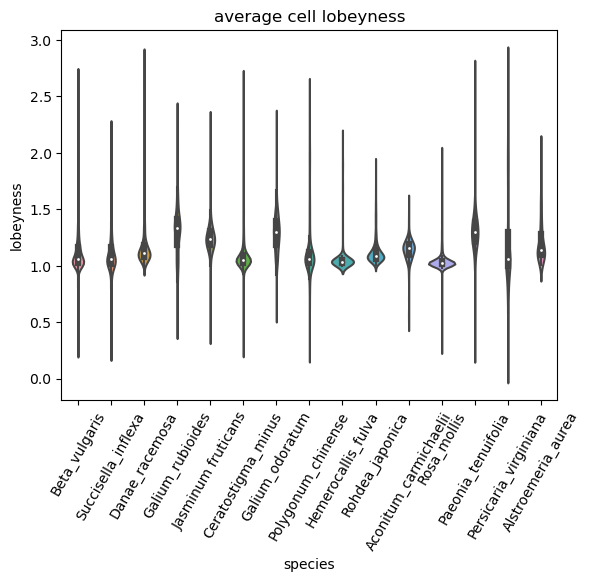

In [127]:
# We cerate fig 6.A in a violin plot : the quantification of cell shape (lobeyness) for every specie

# install seaborn in conda environment and import it 
import seaborn as sns

sns.violinplot(x=df["specie"], y=df["lobeyness"])

# set title and labels 
plt.xticks(rotation = 60) 
plt.title("average cell lobeyness")
plt.xlabel("species")
plt.ylabel("lobeyness")
plt.show()

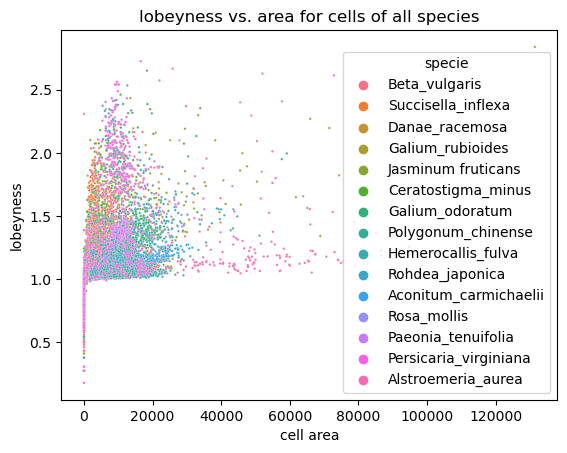

In [128]:
# we create fig 6.C with the lobeyness according to the area of the cell of the image for every specie

# create a scatter plot with seaborn

sns.scatterplot(x=df["area"], y=df["lobeyness"], hue= df["specie"], s=3) # réduire taille des points et les mettres en couleur

# set title and labels 

plt.title("lobeyness vs. area for cells of all species")
plt.xlabel("cell area")
plt.ylabel("lobeyness")
plt.show()